## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import rebound as rb
import celmech as cm
from celmech.miscellaneous import frequency_modified_fourier_transform as fmft

try:
    plt.style.use('/Users/dtamayo/.matplotlib/paper.mplstyle')
except:
    pass

## Load asteroid data and create simulation

In [2]:
# Read the table with the defined column specifications
df = pd.read_fwf('MPCORB.DAT', colspecs=[[0,7], [8,14], [15,19], [20,25], [26,35], [36,46], [47, 57], [58,68], [69,81], [82, 91], [92, 103]])
df = df[df['Epoch'] == 'K239D'] # take only ones at common epoch--almost all of them

df.infer_objects()
for c in ['a', 'e', 'Incl.', 'Node', 'Peri.', 'M']:
    df[c] = pd.to_numeric(df[c])

df.head()

,Des'n,H,G,Epoch,M,Peri.,Node,Incl.,e,n,a
1,00001,3.34,0.15,K239D,60.07879,73.42179,80.25496,10.58688,0.078913,.21410680,2.767254
2,00002,4.12,0.15,K239D,40.59806,310.87290,172.91881,34.92584,0.230229,.21377378,2.770128
3,00003,5.17,0.15,K239D,37.02310,247.73791,169.83920,12.99055,0.256213,.22600445,2.669263
4,00004,3.22,0.15,K239D,169.35183,151.66223,103.71002,7.14218,0.089449,.27152244,2.361922
5,00005,7.00,0.15,K239D,303.39802,359.13666,141.46909,5.35867,0.187439,.23826556,2.576886


In [3]:
labels = pd.read_fwf('proper_catalog24.dat', colspecs=[[0,10], [10,18], [19,28], [29,37], [38, 46], [47,55], [56,66], [67,78], [79,85], [86, 89], [90, 97]], header=None, index_col=False, names=['propa', 'da', 'prope', 'de', 'propsini', 'dsini', 'g', 's', 'H', 'NumOpps', "Des'n"])
labels.head()

,propa,da,prope,de,propsini,dsini,g,s,H,NumOpps,Des'n
0,2.767028,2.300000e-05,0.115193,0.00016,0.167560,0.000013,54.253800,-59.249995,3.34,123,00001
1,2.771276,1.200000e-04,0.280234,0.00034,0.546016,0.000045,-1.372312,-46.451120,4.12,121,00002
2,2.669376,7.500000e-06,0.233600,0.00001,0.229144,0.000003,43.858531,-61.476025,5.17,114,00003
3,2.361512,5.900000e-08,0.099452,0.00014,0.111023,0.000180,36.882605,-39.610314,3.22,110,00004
4,2.577657,2.900000e-05,0.171249,0.01200,0.076113,0.001400,52.506470,-51.132322,7.00,87,00005


In [4]:
merged_df = pd.merge(df, labels, on="Des'n", how="inner")
merged_df.shape, labels.shape

((1249051, 21), (1249051, 11))

In [5]:
sim = rb.Simulation('planets.bin')
# sim = rb.Simulation()
# date = "2023-09-13 12:00"
# sim.add("Sun", date=date)
# sim.add("Jupiter", date=date)
# sim.add("Saturn", date=date)
# sim.add("Uranus", date=date)
# sim.add("Neptune", date=date)

/home/miniconda3/envs/kdey/lib/python3.12/site-packages/rebound/simulation.py:153: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)


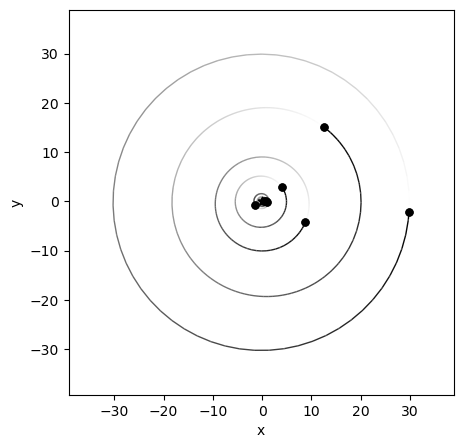

In [6]:
rb.OrbitPlot(sim)

In [7]:
asteroid_num = 2
row = merged_df.iloc[asteroid_num]
row

Des'n           00003
H_x              5.17
G                0.15
Epoch           K239D
M             37.0231
Peri.       247.73791
Node         169.8392
Incl.        12.99055
e            0.256213
n           .22600445
a            2.669263
propa        2.669376
da           0.000008
prope          0.2336
de            0.00001
propsini     0.229144
dsini        0.000003
g           43.858531
s          -61.476025
H_y              5.17
NumOpps           114
Name: 2, dtype: object

2.6641638658343627

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


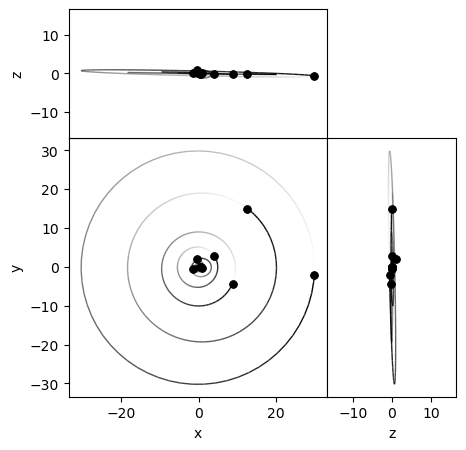

In [8]:
sim = rb.Simulation('planets.bin')
sim.add(a=row['a'], e=row['e'], inc=row['Incl.'], Omega=row['Node'], omega=row['Peri.'], M=row['M'], primary=sim.particles[0])

# sim = rb.Simulation()
# sim.add("Sun", date=date)
# sim.add("Jupiter", date=date)
# sim.add("Saturn", date=date)
# sim.add("Uranus", date=date)
# sim.add("Neptune", date=date)

# sim.add(a=row['a'], e=row['e'], inc=row['Incl.']*np.pi/180, Omega=row['Node']*np.pi/180, omega=row['Peri.']*np.pi/180, M=row['M'], primary=sim.particles[0])
# sim.move_to_com()

rb.OrbitPlotSet(sim)

ps = sim.particles
ps[-1].a

In [9]:
%%time

sim.integrator='whfast'
sim.dt = ps[1].P/100.
sim.ri_whfast.safe_mode = 0

Tfin_approx = 1.5e6*ps[-1].P
total_steps = np.ceil(Tfin_approx / sim.dt)
Tfin = total_steps * sim.dt + sim.dt
Nout = 262144

sim.save_to_file(f"asteroid_integration_{asteroid_num}.sa", step=int(np.floor(total_steps/Nout)), delete_file=True)
sim.integrate(Tfin, exact_finish_time=0)

CPU times: user 55min 12s, sys: 13.6 s, total: 55min 26s
Wall time: 55min 29s


/home/miniconda3/envs/kdey/lib/python3.12/site-packages/rebound/simulationarchive.py:152: RuntimeWarning: The simulation might not be synchronized. You can manually synchronize it by calling sim.integrator_synchronize().
  warnings.warn("The simulation might not be synchronized. You can manually synchronize it by calling sim.integrator_synchronize().", RuntimeWarning)


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


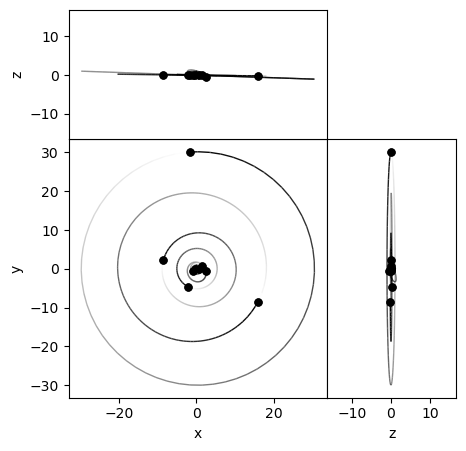

In [10]:
results = cm.nbody_simulation_utilities.get_simarchive_integration_results(f"asteroid_integration_{asteroid_num}.sa",coordinates='heliocentric')
rb.OrbitPlotSet(sim)

(2.6731150209992536, 2.669376)

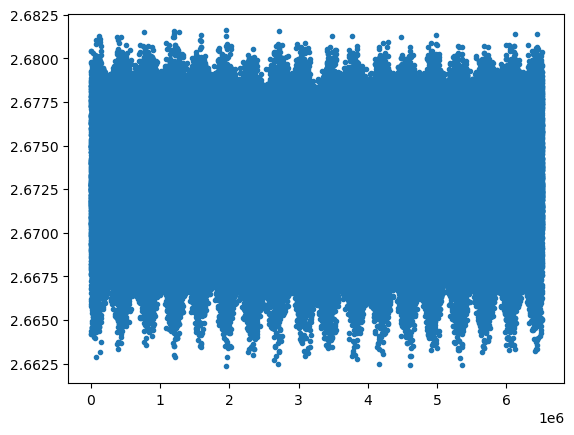

In [11]:
fig, ax = plt.subplots()
ax.plot(results['time'], results['a'][-1], '.')

results['a'][-1].mean(), merged_df.iloc[asteroid_num]['propa']

## Calculate frequencies of planets and asteroid

In [12]:
def closest_key_entry(d, target):
    """
    Given a dictionary `d` with float keys and a target float `target`,
    returns a tuple (key, value) where the key is the one in `d`
    closest to `target`.

    Parameters
    ----------
    d : dict
        Dictionary with float keys.
    target : float
        The float to compare keys against.

    Returns
    -------
    tuple
        The (key, value) pair whose key is closest to `target`.
    """
    closest_key = min(d.keys(), key=lambda k: abs(k - target))
    return closest_key, d[closest_key]

In [13]:
results['X'] = np.sqrt(2*(1-np.sqrt(1-results['e']**2))) * np.exp(1j * results['pomega'])
results['Y'] = (1-results['e']**2)**(0.25) * np.sin(0.5 * results['inc'] )* np.exp(1j * results['Omega'])

In [14]:
planets = ("Jupiter","Saturn","Uranus","Neptune", "Asteroid")
ecc_fmft_results = dict()
inc_fmft_results = dict()
for i,pl in enumerate(planets):
    ecc_fmft_results[pl] = fmft(results['time'],results['X'][i],14)
    planet_e_freqs = np.array(list(ecc_fmft_results[pl].keys()))
    planet_e_freqs_arcsec_per_yr = planet_e_freqs * 60*60*180/np.pi * (2*np.pi)

    inc_fmft_results[pl] = fmft(results['time'],results['Y'][i],8)
    planet_inc_freqs = np.array(list(inc_fmft_results[pl].keys()))
    planet_inc_freqs_arcsec_per_yr = planet_inc_freqs * 60*60*180/np.pi * (2*np.pi)

    print("")
    print(pl)
    print("g")
    print("-------")
    for g in planet_e_freqs[:6]:
        print("{:+07.3f} \t {:0.6f}".format(g * 60 * 60 * 180 / np.pi * (2 * np.pi), np.abs(ecc_fmft_results[pl][g])))
    print("s")
    print("-------")
    for g in planet_inc_freqs[:4]:
        print("{:+07.3f} \t {:0.6f}".format(g * 60 * 60 * 180 / np.pi * (2 * np.pi), np.abs(inc_fmft_results[pl][g])))


Jupiter
g
-------
+32.773 	 0.167893
+26.763 	 0.041956
+46.104 	 0.023984
+39.358 	 0.009676
+24.584 	 0.008121
+34.071 	 0.006977
s
-------
-34.549 	 0.058787
-00.000 	 0.013622
-42.387 	 0.009683
-40.408 	 0.006228



Saturn
g
-------
+46.095 	 0.022698
+26.749 	 0.020586
+112.313 	 0.013253
+108.773 	 0.013094
+32.773 	 0.005113
+107.165 	 0.003299
s
-------
-00.000 	 0.013772
-118.523 	 0.009636
-34.531 	 0.008035
-111.435 	 0.005664



Uranus
g
-------
+26.747 	 0.019662
+46.095 	 0.017542
+112.295 	 0.013030
+108.791 	 0.010862
+32.769 	 0.003199
+107.082 	 0.002664
s
-------
-00.000 	 0.013774
-118.524 	 0.008823
-34.523 	 0.005977
-111.437 	 0.003947



Neptune
g
-------
+112.221 	 0.051044
+108.714 	 0.032049
+26.749 	 0.020474
+105.143 	 0.016523
+110.693 	 0.016479
+115.780 	 0.013792
s
-------
-111.422 	 0.034574
-118.534 	 0.014927
-00.000 	 0.013741
-115.003 	 0.007302



Asteroid
g
-------
+26.747 	 0.044190
+177.468 	 0.015708
+19.402 	 0.001820
-133611.170 	 0.000645
+328.189 	 0.000572
-51053.227 	 0.000396
s
-------
-00.000 	 0.013767
-165.549 	 0.003149
-04.346 	 0.000577
-18.802 	 0.000481


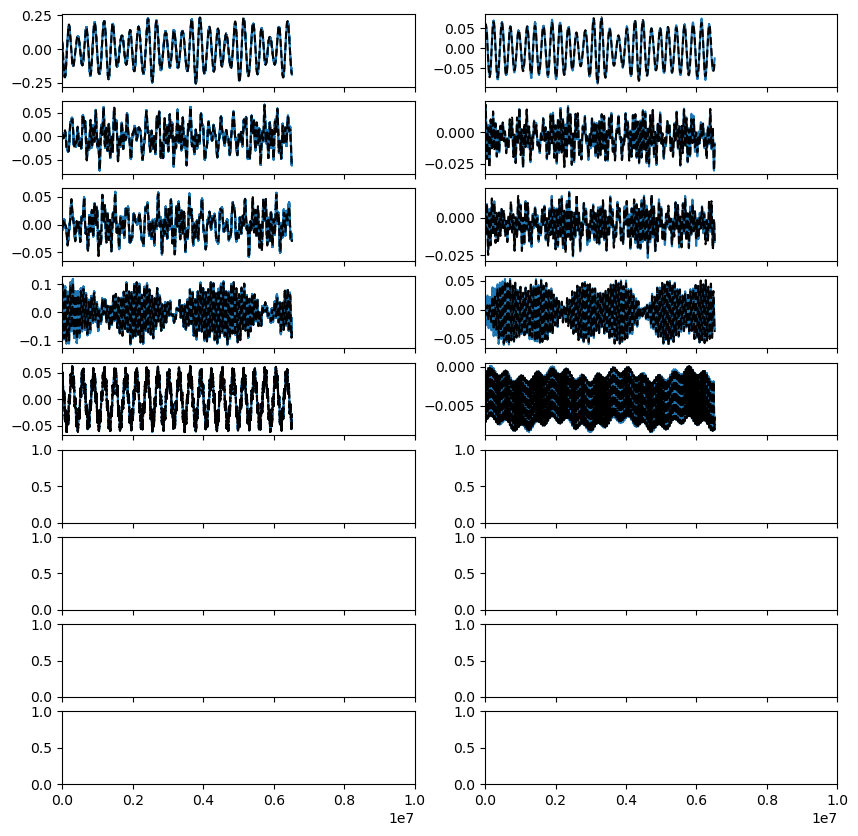

In [15]:
fig,ax = plt.subplots(sim.N-1,2,sharex=True,figsize=(10,10))
Xsolns = []
Ysolns = []
for i,pl in enumerate(planets):
    freq_amp_dict = ecc_fmft_results[pl]
    ax[i,0].plot(results['time'],np.real(results['X'][i]))
    zsoln = np.sum([amp * np.exp(1j*freq*results['time']) for freq,amp in freq_amp_dict.items()],axis=0)
    ax[i,0].plot(results['time'],np.real(zsoln),'k--')

    freq_amp_dict = inc_fmft_results[pl]
    Ysolns.append(freq_amp_dict)
    ax[i,1].plot(results['time'],np.real(results['Y'][i]))
    zsoln = np.sum([amp * np.exp(1j*freq*results['time']) for freq,amp in freq_amp_dict.items()],axis=0)
    ax[i,1].plot(results['time'],np.real(zsoln),'k--')
plt.xlim(0,1e7)
plt.show()

In [16]:
ARCSEC_PER_YR = 1/(180*60*60*2)
g_vec = np.zeros(4)
s_vec = np.zeros(3)

g_vec[:3] = np.array(list(ecc_fmft_results['Jupiter'].keys()))[:3]
g_vec[3] = list(ecc_fmft_results['Neptune'].keys())[0]
s_vec[0] = list(inc_fmft_results['Jupiter'].keys())[0]
s_vec[1] = list(inc_fmft_results['Jupiter'].keys())[2]
s_vec[2] = list(inc_fmft_results['Jupiter'].keys())[1]
omega_vec = np.concatenate((g_vec,s_vec))
g_and_s_arc_sec_per_yr = omega_vec / ARCSEC_PER_YR
g_and_s_arc_sec_per_yr

array([ 3.27726234e+01,  2.67625411e+01,  4.61038699e+01,  1.12221278e+02,
       -3.45486816e+01, -4.23872856e+01, -1.51319890e-04])

In [17]:
eye_N = np.eye(omega_vec.size,dtype = int)
x_dicts = []
for pl in planets:
    print(pl)    
    print("-"*len(pl))
    print("kvec \t\t\t omega \t err. \t amplitude")
    x_dict = {}
    for i,omega_i in enumerate(omega_vec[:4]):
        omega_N,amp = closest_key_entry(ecc_fmft_results[pl],omega_vec[i])
        omega_error = np.abs(omega_N/omega_i-1)
        if omega_error<0.001:
            print (eye_N[i],"\t{:+07.3f}\t{:.1g} \t{:.1g}".format(omega_i/ARCSEC_PER_YR,omega_error,np.abs(amp)))
            x_dict[tuple(eye_N[i])] = amp
    #NL terms
    for a in range(7):
        for b in range(a,7):
            for c in range(7):
                if c==a:
                    continue
                if c==b:
                    continue
                k = np.zeros(7,dtype = int)
                k[a] +=1
                k[b] +=1
                k[c] -=1
                omega=k@omega_vec
                omega_N,amp = closest_key_entry(ecc_fmft_results[pl],omega)
                omega_error = np.abs(omega_N/omega-1)
                if omega_error<0.001:
                    print (k,"\t{:+07.3f}\t{:.1g},\t{:.1g}".format(omega/ARCSEC_PER_YR,omega_error,np.abs(amp)))
                    x_dict[tuple(k)] = amp
    x_dicts.append(x_dict)

Jupiter
-------
kvec 			 omega 	 err. 	 amplitude
[1 0 0 0 0 0 0] 	+32.773	0 	0.2
[0 1 0 0 0 0 0] 	+26.763	0 	0.04
[0 0 1 0 0 0 0] 	+46.104	0 	0.02
[-1  0  0  0  2  0  0] 	-101.870	0.0002,	0.002
Saturn
------
kvec 			 omega 	 err. 	 amplitude
[1 0 0 0 0 0 0] 	+32.773	1e-05 	0.005
[0 1 0 0 0 0 0] 	+26.763	0.0005 	0.02
[0 0 1 0 0 0 0] 	+46.104	0.0002 	0.02
[0 0 0 1 0 0 0] 	+112.221	0.0008 	0.01
[ 1  1  0  0  0 -1  0] 	+101.922	0.0004,	0.0006
Uranus
------
kvec 			 omega 	 err. 	 amplitude
[1 0 0 0 0 0 0] 	+32.773	0.0001 	0.003
[0 1 0 0 0 0 0] 	+26.763	0.0006 	0.02
[0 0 1 0 0 0 0] 	+46.104	0.0002 	0.02
[0 0 0 1 0 0 0] 	+112.221	0.0007 	0.01
Neptune
-------
kvec 			 omega 	 err. 	 amplitude
[0 1 0 0 0 0 0] 	+26.763	0.0005 	0.02
[0 0 1 0 0 0 0] 	+46.104	0.0002 	0.003
[0 0 0 1 0 0 0] 	+112.221	0 	0.05
[ 0  0  0  1 -1  1  0] 	+104.383	0.0006,	0.001
Asteroid
--------
kvec 			 omega 	 err. 	 amplitude
[0 1 0 0 0 0 0] 	+26.763	0.0006 	0.04
[ 0  1  0  1 -1  0  0] 	+173.533	5e-06,	0.0001
[ 0  1  0

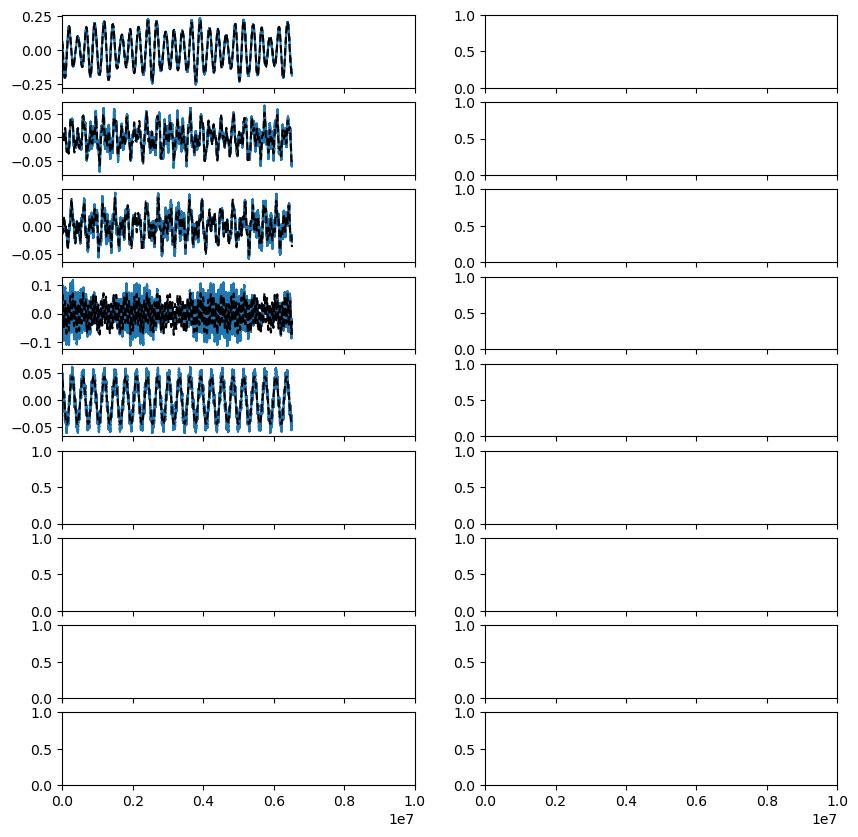

In [18]:
fig,ax = plt.subplots(sim.N-1,2,sharex=True,figsize=(10,10))
Xsolns = []
Ysolns = []
for i,pl in enumerate(planets):
    freq_amp_dict = ecc_fmft_results[pl]
    ax[i,0].plot(results['time'],np.real(results['X'][i]))
    zsoln = np.sum([np.abs(amp) * np.exp(1j*((np.array(k)@omega_vec)*results['time'] + + np.angle(amp))) for k,amp in x_dicts[i].items()],axis=0)
    ax[i,0].plot(results['time'],np.real(zsoln),'k--')
plt.xlim(0,1e7) 
plt.show()

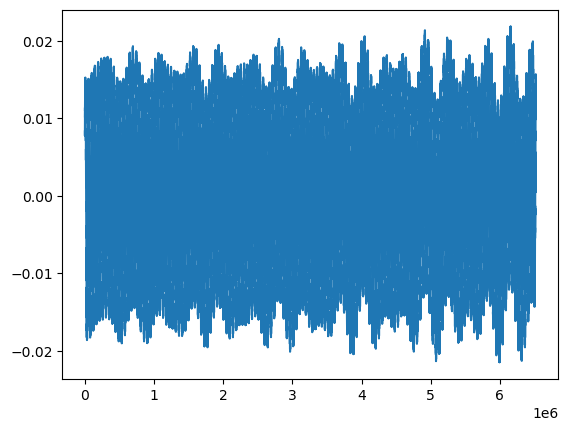

In [19]:
freq_amp_dict = ecc_fmft_results['Asteroid']
zsoln = np.sum([np.abs(amp) * np.exp(1j*((np.array(k)@omega_vec)*results['time'] + + np.angle(amp))) for k,amp in x_dicts[-1].items()],axis=0)
soln_wo_planets = results['X'][i] - zsoln
plt.plot(results['time'], np.real(soln_wo_planets))

In [20]:
ecc_fmft_result = fmft(results['time'], soln_wo_planets, 14)

asteroid_e_freqs = np.array(list(ecc_fmft_result.keys()))
asteroid_e_freqs_arcsec_per_yr = asteroid_e_freqs * 60*60*180/np.pi * (2*np.pi)

print("")
print(pl)
print("g")
print("-------")
for g in asteroid_e_freqs[:6]:
    print("{:+07.3f} \t {:0.6f}".format(g * 60 * 60 * 180 / np.pi * (2 * np.pi), np.abs(ecc_fmft_result[g])))


Asteroid
g
-------
+177.468 	 0.015708
+19.403 	 0.001820
+26.759 	 0.001765
-133611.170 	 0.000645
+328.189 	 0.000572
+27.598 	 0.000490
